# 2-2,自动微分机制

神经网络通常依赖反向传播求梯度来更新网络参数，求梯度过程通常是一件非常复杂而容易出错的事情。

而深度学习框架可以帮助我们自动地完成这种求梯度运算。

Pytorch一般通过反向传播 backward 方法 实现这种求梯度计算。该方法求得的梯度将存在对应自变量张量的grad属性下。

**除此之外，也能够调用torch.autograd.grad 函数来实现求梯度计算，但用的比较少，一般用来求高阶导数。**

这就是Pytorch的自动微分机制。

In [1]:
import os
import datetime
import torchkeras

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 
from python_cgtools.utils_date import *
from python_cgtools.utils_torch import *

torch.__version__ =  2.0.1+cu118
torchvision.__version__ =  0.15.2+cu118
pytorch_lightning.__version__ =  2.0.2
torchtext.__version__ =  0.15.2
torchdata.__version__ =  0.6.1
torchmetrics.__version__ =  0.11.4
torchkeras.__version__ =  3.8.2
yaml.__version__ =  6.0
tensorflow sed random seed fail.


```
torch.__version__=1.10.0
```

In [2]:
start_time = time.time()
print_with_time("start.........")

2023-05-29 00:42:39:start.........


### 一，利用backward方法求导数

backward 方法通常在一个标量张量上调用，该方法求得的梯度将存在对应自变量张量的grad属性下。

如果调用的张量非标量，则要传入一个和它同形状 的gradient参数张量。

相当于用该gradient参数张量与调用张量作向量点乘，得到的标量结果再反向传播。


**1, 标量的反向传播**

In [3]:
import numpy as np 
import torch 

# f(x) = a*x**2 + b*x + c的导数

x = torch.tensor(0.0,requires_grad = True) # x需要被求导
a = torch.tensor(1.0)
b = torch.tensor(-2.0)
c = torch.tensor(1.0)
y = a*torch.pow(x,2) + b*x + c 

y.backward()
dy_dx = x.grad
# tensor(-2.)
print(dy_dx)


tensor(-2.)


```
tensor(-2.)
```

In [4]:
import numpy as np 
import torch 

x = torch.tensor([0.0, 0.0],requires_grad = True) # x需要被求导
y = torch.pow(x,2)

# RuntimeError: grad can be implicitly created only for scalar outputs
# 求导默认只能对标量来求，一般模型的 loss 都是标量
# y.backward()

In [5]:
import numpy as np 
import torch 

x = torch.tensor([0.0],requires_grad = False)
y = torch.pow(x,2)

# RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn
# 能求导要求包含自变量，即 requires_grad=True 的量
# y.backward()

**2, 非标量的反向传播**

In [6]:
import numpy as np 
import torch 

# f(x) = a*x**2 + b*x + c

x = torch.tensor([[0.0,0.0],[1.0,2.0]],requires_grad = True) # x需要被求导
a = torch.tensor(1.0)
b = torch.tensor(-2.0)
c = torch.tensor(1.0)
# [0, 0, 1, 4] - [0, 0, 2, 4] + 1 = [1, 1, 0, 1]
y = a*torch.pow(x,2) + b*x + c 

gradient = torch.tensor([[1.0,1.0],[1.0,1.0]])

# x:
#  tensor([[0., 0.],
#         [1., 2.]], requires_grad=True)
# y:
#  tensor([[1., 1.],
#         [0., 1.]], grad_fn=<AddBackward0>)
# x_grad:
#  tensor([[-2., -2.],
#         [ 0.,  2.]])
print("x:\n",x)
print("y:\n",y)
y.backward(gradient = gradient)
x_grad = x.grad
print("x_grad:\n",x_grad)

x:
 tensor([[0., 0.],
        [1., 2.]], requires_grad=True)
y:
 tensor([[1., 1.],
        [0., 1.]], grad_fn=<AddBackward0>)
x_grad:
 tensor([[-2., -2.],
        [ 0.,  2.]])


```
x:
 tensor([[0., 0.],
        [1., 2.]], requires_grad=True)
y:
 tensor([[1., 1.],
        [0., 1.]], grad_fn=<AddBackward0>)
x_grad:
 tensor([[-2., -2.],
        [ 0.,  2.]])
```

**3, 非标量的反向传播可以用标量的反向传播实现**

In [7]:
import numpy as np 
import torch 

# f(x) = a*x**2 + b*x + c

x = torch.tensor([[0.0,0.0],[1.0,2.0]],requires_grad = True) # x需要被求导
a = torch.tensor(1.0)
b = torch.tensor(-2.0)
c = torch.tensor(1.0)
y = a*torch.pow(x,2) + b*x + c 

gradient = torch.tensor([[1.0,1.0],[1.0,1.0]])
# 将结果变成一个标量，如果 gradient 都是元素1，相当于将各个分量相加，对于此例来说，x 的分量之间没有耦合，因此结果等价于每个分量独立求导
# 注意是偏导
# z = (2a^2 - 2a + 1) + (2b^2 - 2b + 1) + (2c^2 - 2c + 1) + (2d^2 - 2d + 1)
# ∂z/∂x_0 = 2a - 2 = -2
# ∂z/∂x_1 = 2b - 2 = -2
# ∂z/∂x_2 = 2c - 2 = 0
# ∂z/∂x_3 = 2d - 2 = 2
z = torch.sum(y*gradient)

# x: tensor([[0., 0.],
#         [1., 2.]], requires_grad=True)
# y: tensor([[1., 1.],
#         [0., 1.]], grad_fn=<AddBackward0>)
# x_grad:
#  tensor([[-2., -2.],
#         [ 0.,  2.]])
print("x:",x)
print("y:",y)
z.backward()
x_grad = x.grad
print("x_grad:\n",x_grad)


x: tensor([[0., 0.],
        [1., 2.]], requires_grad=True)
y: tensor([[1., 1.],
        [0., 1.]], grad_fn=<AddBackward0>)
x_grad:
 tensor([[-2., -2.],
        [ 0.,  2.]])


```
x: tensor([[0., 0.],
        [1., 2.]], requires_grad=True)
y: tensor([[1., 1.],
        [0., 1.]], grad_fn=<AddBackward0>)
x_grad:
 tensor([[-2., -2.],
        [ 0.,  2.]])
```

In [8]:
import numpy as np 
import torch 

# f(x) = a*x**2 + b*x + c

x = torch.tensor([[0.0,0.0],[1.0,2.0]],requires_grad = True) # x需要被求导
y = torch.matmul(x, x)

gradient = torch.tensor([[1.0,1.0],[1.0,1.0]])
# 如果标量对于 x 的分量并不独立，即分量之间有交叉，那么结果会更复杂一些
# z = [[a, b], [c, d]] * [[a, b], [c, d]] = (a^2 + bc) + (ab + bd) + (ca + dc) + (cb + d^2) = a^2 + ab + ac + 2bc + bd + cd + d^2
# a = 0, b = 0, c = 1, d = 2
# ∂z/∂a = 2a + b + c = 1
# ∂z/∂b = a + 2c + d = 4
# ∂z/∂c = a + 2b + d = 2
# ∂z/∂d = b + c + 2d = 5
z = torch.sum(y*gradient)

# x: tensor([[0., 0.],
#         [1., 2.]], requires_grad=True)
# y: tensor([[0., 0.],
#         [2., 4.]], grad_fn=<MmBackward0>)
# x_grad:
#  tensor([[1., 4.],
#         [2., 5.]])
print("x:",x)
print("y:",y)
z.backward()
x_grad = x.grad
print("x_grad:\n",x_grad)


x: tensor([[0., 0.],
        [1., 2.]], requires_grad=True)
y: tensor([[0., 0.],
        [2., 4.]], grad_fn=<MmBackward0>)
x_grad:
 tensor([[1., 4.],
        [2., 5.]])


In [9]:
import numpy as np 
import torch 

# f(x) = a*x**2 + b*x + c

x = torch.tensor([[0.0,0.0],[1.0,2.0]],requires_grad = True) # x需要被求导
y = torch.matmul(x, x)

gradient = torch.tensor([[1.0,1.0],[1.0,1.0]])
# 如果标量对于 x 的分量并不独立，即分量之间有交叉，那么结果会更复杂一些
# z = [[a, b], [c, d]] * [[a, b], [c, d]] = (a^2 + bc) + (ab + bd) + (ca + dc) + (cb + d^2) = a^2 + ab + ac + 2bc + bd + cd + d^2
# a = 0, b = 0, c = 1, d = 2
# ∂z/∂a = 2a + b + c = 1
# ∂z/∂b = a + 2c + d = 4
# ∂z/∂c = a + 2b + d = 2
# ∂z/∂d = b + c + 2d = 5
z = torch.sum(y*gradient)

# x: tensor([[0., 0.],
#         [1., 2.]], requires_grad=True)
# y: tensor([[0., 0.],
#         [2., 4.]], grad_fn=<MmBackward0>)
# x_grad:
#  tensor([[ 2.,  8.],
#         [ 4., 10.]])
print("x:",x)
print("y:",y)
# 如果要多次求梯度，首先要把 retain_graph 设置成 True，然后 pytorch 默认会把多次求梯度的结果加和
# 对于此例可以看到梯度结果乘以了 2
z.backward(retain_graph=True)
z.backward()
x_grad = x.grad
print("x_grad:\n",x_grad)


x: tensor([[0., 0.],
        [1., 2.]], requires_grad=True)
y: tensor([[0., 0.],
        [2., 4.]], grad_fn=<MmBackward0>)
x_grad:
 tensor([[ 2.,  8.],
        [ 4., 10.]])


### 二，利用autograd.grad方法求导数

In [10]:
import numpy as np 
import torch 

# f(x) = a*x**2 + b*x + c的导数

x = torch.tensor(0.0,requires_grad = True) # x需要被求导
a = torch.tensor(1.0)
b = torch.tensor(-2.0)
c = torch.tensor(1.0)
y = a*torch.pow(x,2) + b*x + c


# create_graph 设置为 True 将允许创建更高阶的导数 
# dy / dx = 2x + b = -2
dy_dx = torch.autograd.grad(y,x,create_graph=True)[0]
# tensor(-2.)
print(dy_dx.data)

# 求二阶导数
# dy2/dx2 = d(2x +b) / dx = 2
dy2_dx2 = torch.autograd.grad(dy_dx,x)[0] 
# tensor(2.)
print(dy2_dx2.data)



tensor(-2.)
tensor(2.)


```
tensor(-2.)
tensor(2.)
```

In [11]:
import numpy as np 
import torch 

x1 = torch.tensor(1.0,requires_grad = True) # x需要被求导
x2 = torch.tensor(2.0,requires_grad = True)

y1 = x1*x2
y2 = x1+x2


# 允许同时对多个自变量求导数
# dy1/dx1 = x2 = 2
# dy1/dx2 = 1
# 必须设置 retain_graph = True,否则
# Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). 
# Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). 
# Specify retain_graph=True if you need to backward through the graph a second time 
# or if you need to access saved tensors after calling backward.
(dy1_dx1,dy1_dx2) = torch.autograd.grad(outputs=y1,inputs = [x1,x2],retain_graph = True)
# tensor(2.) tensor(1.)
print(dy1_dx1,dy1_dx2)

# 如果有多个因变量，相当于把多个因变量的梯度结果求和
# dy1/dx1 + dy2/dx1 = x2 + 1 = 3
# dy1/dx2 + dy2/dx2 = x1 + 1 = 2
(dy12_dx1,dy12_dx2) = torch.autograd.grad(outputs=[y1,y2],inputs = [x1,x2])
print(dy12_dx1,dy12_dx2)



tensor(2.) tensor(1.)
tensor(3.) tensor(2.)


```
tensor(2.) tensor(1.)
tensor(3.) tensor(2.)
```

### 三，利用自动微分和优化器求极值（不一定是最）

In [12]:
import numpy as np 
import torch 

# f(x) = a*x**2 + b*x + c的最小值

x = torch.tensor(0.0,requires_grad = True) # x需要被求导
a = torch.tensor(1.0)
b = torch.tensor(-2.0)
c = torch.tensor(1.0)

optimizer = torch.optim.SGD(params=[x],lr = 0.01)


def f(x):
    result = a*torch.pow(x,2) + b*x + c 
    return(result)

# 其实就是模拟了梯度下降，注意 y = f(x) 每次都会用新的 x 重新计算，相当于每个 batch 结束后，要更新输入，重新算梯度
x_list = list()
y_list = list()
grad_list = list()
for i in range(500):
    optimizer.zero_grad()
    x_list.append(x.item())
    y = f(x)
    y.backward()
    optimizer.step()
#     要放在 optimizer.step() 前面，否则 x 的值会被梯度下降更新
#     x_list.append(x.item())
    y_list.append(y.item())
    grad_list.append(x.grad.item())
    
print("y=",f(x).data,";","x=",x.data)


y= tensor(0.) ; x= tensor(1.0000)


```
y= tensor(0.) ; x= tensor(1.0000)
```

In [13]:
# x	y	grad
# 0	0.020000	1.000000	-2.000000
# 1	0.039600	0.960400	-1.960000
# 2	0.058808	0.922368	-1.920800
# 3	0.077632	0.885842	-1.882384
# 4	0.096079	0.850763	-1.844736
# ...	...	...	...
# 495	0.999956	0.000000	-0.000091
# 496	0.999956	0.000000	-0.000089
# 497	0.999957	0.000000	-0.000087
# 498	0.999958	0.000000	-0.000085
# 499	0.999959	0.000000	-0.000084
df = pd.DataFrame(zip(x_list, y_list, grad_list), columns=["x", "y", "grad"])
df

,x,y,grad
0,0.000000,1.000000,-2.000000
1,0.020000,0.960400,-1.960000
2,0.039600,0.922368,-1.920800
3,0.058808,0.885842,-1.882384
4,0.077632,0.850763,-1.844736
...,...,...,...
495,0.999955,0.000000,-0.000091
496,0.999956,0.000000,-0.000089
497,0.999956,0.000000,-0.000087
498,0.999957,0.000000,-0.000085


<AxesSubplot:>

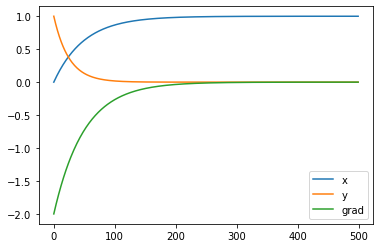

In [14]:
df.plot()

**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)